In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms
import cv2

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from sklearn.metrics import classification_report

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../../data/SkinCancer/train')
data_dir_test = pathlib.Path('../../data/SkinCancer/test')
data_dir_val = pathlib.Path('../../data/SkinCancer/val')

In [4]:
# DataLoader for training data
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        data_dir_train,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    ),
    batch_size=128,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        data_dir_test,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    ),
    batch_size=128,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        data_dir_val,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    ),
    batch_size=1,
    shuffle=True 
)

In [5]:
len(train_loader)*128, len(test_loader)*128, len(val_loader)

(2688, 640, 95)

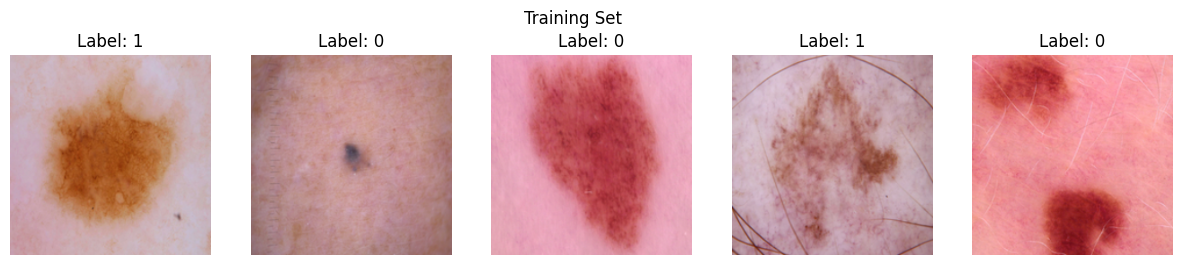

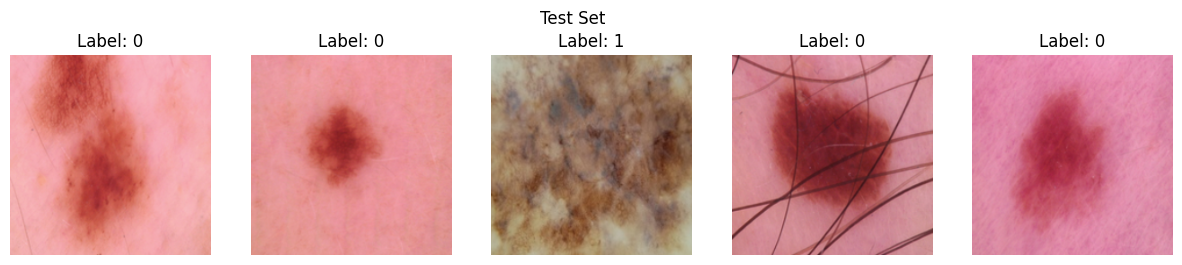

In [6]:
# plot the first 5 images in the training set, the first 5 images in the test set
def plot_images(loader, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, (image, label) in enumerate(loader):
        if i == 5:
            break
        axs[i].imshow(image[i].permute(1, 2, 0))
        axs[i].set_title(f"Label: {label[i].item()}")
        axs[i].axis("off")
    fig.suptitle(title)
    plt.show()

plot_images(train_loader, "Training Set")
plot_images(test_loader, "Test Set")

In [7]:
# create a custom convolutional neural network model for the classification task

class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu1 = torch.nn.LeakyReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = torch.nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.relu2 = torch.nn.LeakyReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = torch.nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.relu3 = torch.nn.LeakyReLU()
        self.conv4 = torch.nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.relu4 = torch.nn.LeakyReLU()
        self.conv5 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu5 = torch.nn.LeakyReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(256 * 6 * 6, 4096)
        self.relu6 = torch.nn.LeakyReLU()
        #self.dropout1 = torch.nn.Dropout()
        self.fc2 = torch.nn.Linear(4096, 4096)
        self.relu7 = torch.nn.LeakyReLU()
        #self.dropout2 = torch.nn.Dropout()
        self.fc3 = torch.nn.Linear(4096, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.pool3(self.relu5(self.conv5(x)))
        x = self.flatten(x)
        x = self.relu6(self.fc1(x))#self.dropout1()
        x = self.relu7(self.fc2(x))#self.dropout2()
        x = self.fc3(x)
        x = self.sigmoid(x)
        x = x.view(-1)
        return x
    
# create model
model = CustomCNN().to(device)
model.load_state_dict(torch.load('./customCNN_1.pth'))
model.to(device)

/tmp/ipykernel_107882/684743882.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./customCNN_1.pth'))


CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): LeakyReLU(negative_slope=0.01)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (relu6): LeakyRe

In [8]:
# test model with a random input
x = torch.randn(1, 3, 224, 224).to(device)
y = model(x)
print(y)

tensor([1.], device='cuda:0', grad_fn=<ViewBackward0>)


In [9]:
# test model with the first batch of the training data
for i, (image, label) in enumerate(train_loader):
    if i == 1:
        break
    image = image.to(device)
    label = label.to(device)
    output = model(image)
    print(output)
    print(label)

tensor([5.6128e-03, 7.6757e-05, 9.9981e-01, 8.1569e-05, 7.1780e-04, 1.3195e-05,
        9.9835e-01, 7.1413e-06, 1.4229e-03, 9.3484e-01, 9.9818e-01, 1.3163e-02,
        5.9661e-02, 5.3810e-06, 9.9996e-01, 9.9998e-01, 1.0798e-06, 9.9549e-01,
        4.6443e-05, 6.9373e-02, 1.0054e-05, 4.1533e-04, 2.6592e-05, 9.3007e-01,
        1.5992e-01, 9.9833e-01, 2.0366e-06, 9.9336e-01, 2.6754e-01, 4.7350e-01,
        9.9143e-01, 5.6258e-04, 1.4369e-02, 9.9971e-01, 9.9863e-01, 1.2438e-04,
        9.9924e-01, 3.2586e-07, 5.6525e-05, 9.9994e-01, 4.2048e-07, 4.2037e-05,
        9.7468e-01, 1.4275e-03, 6.8882e-06, 9.9713e-01, 7.9826e-03, 2.1059e-01,
        5.6678e-02, 9.9248e-01, 3.4145e-05, 9.9984e-01, 9.9963e-01, 9.9966e-01,
        9.5632e-01, 2.4554e-05, 5.5904e-05, 9.9995e-01, 9.9742e-01, 1.0073e-05,
        9.8707e-01, 2.5619e-06, 9.2759e-01, 2.1123e-05, 9.9601e-01, 9.9967e-01,
        9.9870e-01, 1.0088e-01, 1.4674e-04, 9.9956e-01, 1.9037e-04, 8.2277e-01,
        9.9909e-01, 2.3936e-05, 9.9760e-

In [10]:
# evaluate the model
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()

In [11]:
# evaluate the model
print("Classification Report")
print(classification_report(labels.cpu().numpy(), predicted.cpu().numpy()))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        29
           1       0.75      1.00      0.86        24

    accuracy                           0.85        53
   macro avg       0.88      0.86      0.85        53
weighted avg       0.89      0.85      0.85        53



In [12]:
# save the model
torch.save(model.state_dict(), "customCNN_1.pth")

---

In [13]:
# take the first 10 images from the validation set
images = []
labels = []
for i in range(10):
    image, label = next(iter(val_loader))
    images.append(image)
    labels.append(label)

In [14]:
images[0].shape

torch.Size([1, 3, 224, 224])

In [15]:
labels[0]

tensor([1])

In [16]:
# remove the model from the GPU
model = model.cpu()
# clean GPU cache
torch.cuda.empty_cache()

In [17]:
interpretabilities_dict = {}
interpretabilities_dict['ig'] = []
interpretabilities_dict['saliency'] = []
interpretabilities_dict['deep_lift'] = []

model.eval()
for i in range(10):
    image = images[i]
    label = labels[i]
    # Integrated Gradients
    ig = IntegratedGradients(model)
    attr_ig, delta_ig = ig.attribute(image, target=None, return_convergence_delta=True, n_steps=300)
    attr_ig = attr_ig.squeeze().cpu().detach().numpy()
    attr_ig_sum_norm = np.sum(np.abs(attr_ig), axis=0)
    attr_ig_sum_norm = attr_ig_sum_norm / np.max(attr_ig_sum_norm)
    interpretabilities_dict['ig'].append(attr_ig_sum_norm)
    # Saliency
    saliency = Saliency(model)
    attr_saliency = saliency.attribute(image, target=None)
    attr_saliency = attr_saliency.squeeze().cpu().detach().numpy()
    attr_saliency_sum_norm = np.sum(np.abs(attr_saliency), axis=0)
    attr_saliency_sum_norm = attr_saliency_sum_norm / np.max(attr_saliency_sum_norm)
    interpretabilities_dict['saliency'].append(attr_saliency_sum_norm)
    # DeepLift
    dl = DeepLift(model)
    attr_dl = dl.attribute(image, target=None)
    attr_dl = attr_dl.squeeze().cpu().detach().numpy()
    attr_dl_sum_norm = np.sum(np.abs(attr_dl), axis=0)
    attr_dl_sum_norm = attr_dl_sum_norm / np.max(attr_dl_sum_norm)
    interpretabilities_dict['deep_lift'].append(attr_dl_sum_norm)

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [18]:
interpretabilities_dict['ig'][0].shape

(224, 224)

In [19]:
interpretabilities_dict['deep_lift'][0].shape

(224, 224)

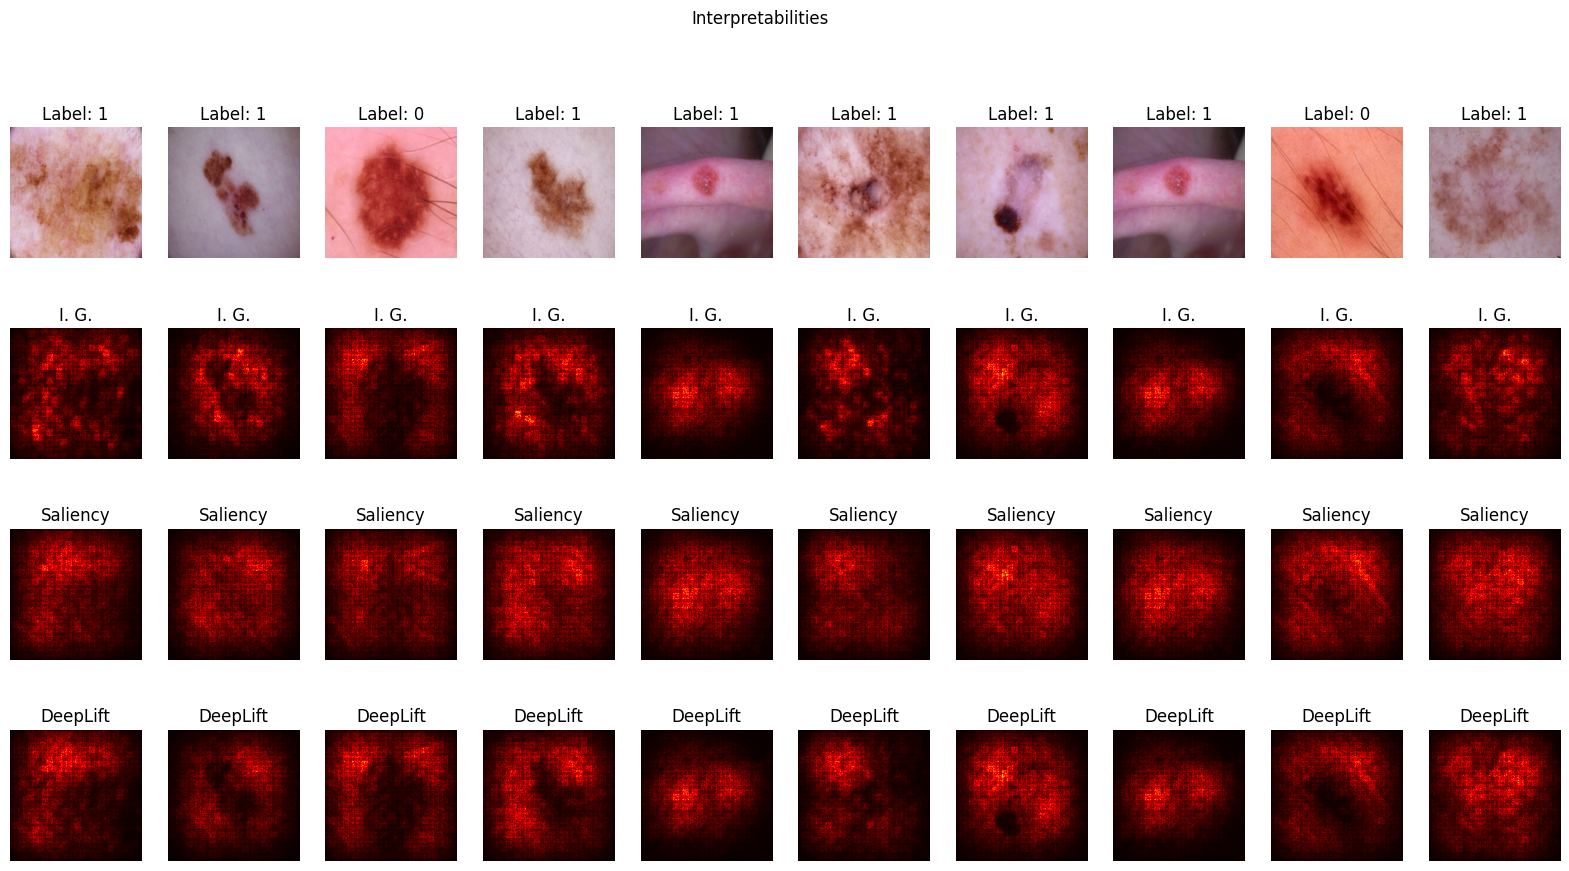

In [20]:
fig, axs = plt.subplots(4, 10, figsize=(20, 10))
for i in range(10):
    axs[0,i].imshow(images[i].squeeze().permute(1, 2, 0))
    axs[0,i].set_title(f"Label: {labels[i].item()}")
    axs[0,i].axis("off")
    axs[1,i].imshow(interpretabilities_dict['ig'][i], cmap="hot")
    axs[1,i].set_title("I. G.")
    axs[1,i].axis("off")
    axs[2,i].imshow(interpretabilities_dict['saliency'][i], cmap="hot")
    axs[2,i].set_title("Saliency")
    axs[2,i].axis("off")
    axs[3,i].imshow(interpretabilities_dict['deep_lift'][i], cmap="hot")
    axs[3,i].set_title("DeepLift")
    axs[3,i].axis("off")
fig.suptitle("Interpretabilities")
plt.show()

---

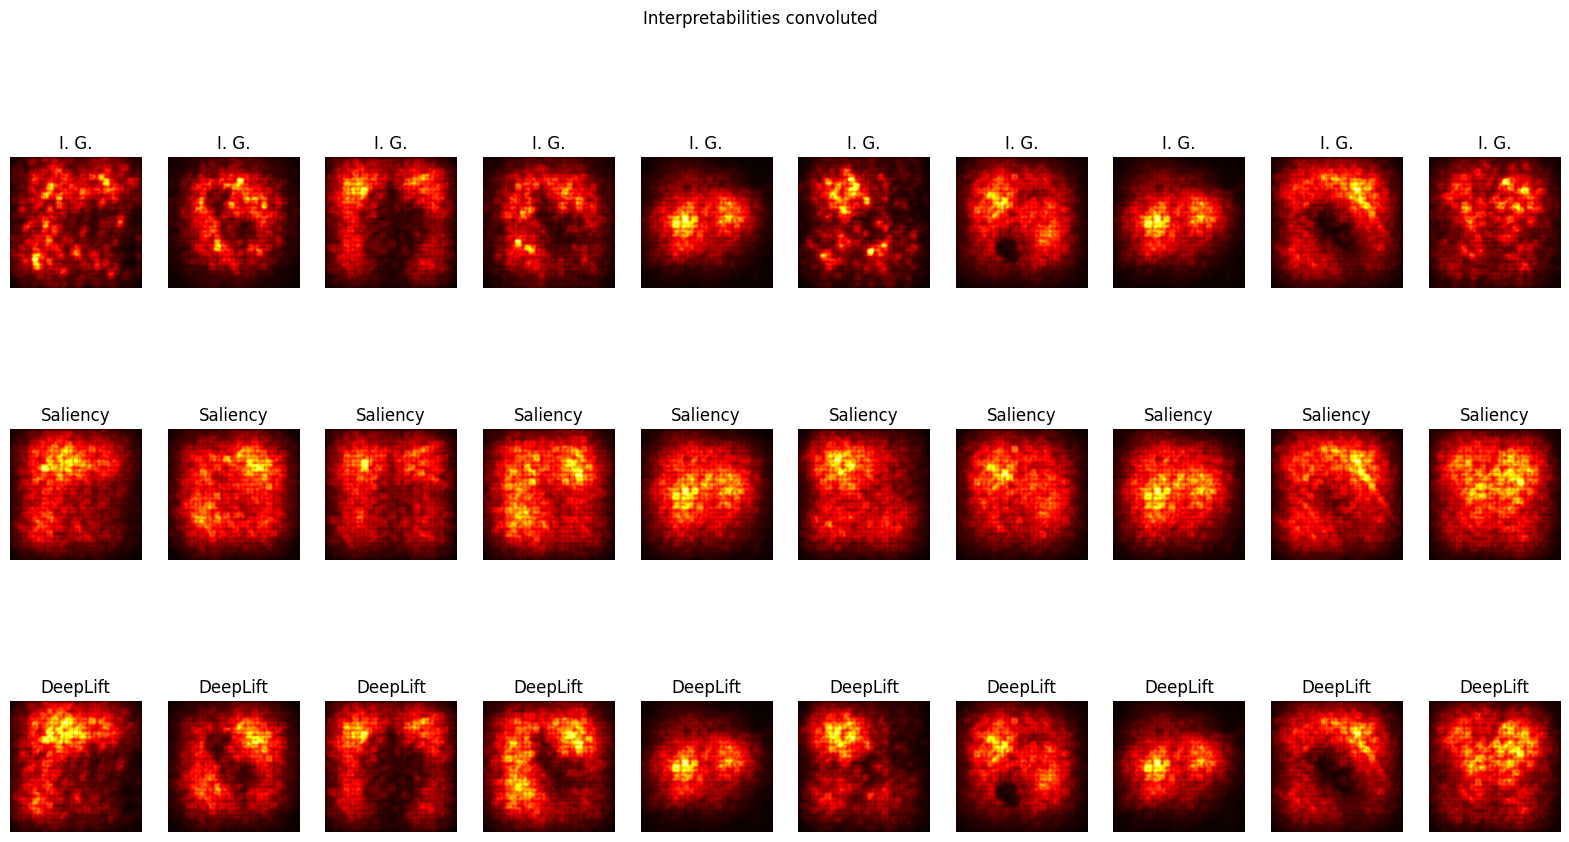

In [21]:
fig, axs = plt.subplots(3, 10, figsize=(20, 10))
for i in range(10):
    # apply convolution filter with opencv
    kernel = np.ones((5,5),np.float32)/25

    ig = interpretabilities_dict['ig'][i]
    ig_filtered = cv2.filter2D(ig,-1,kernel)
    axs[0,i].imshow(ig_filtered, cmap="hot")
    axs[0,i].set_title("I. G.")
    axs[0,i].axis("off")

    saliency = interpretabilities_dict['saliency'][i]
    saliency_filtered = cv2.filter2D(saliency,-1,kernel)
    axs[1,i].imshow(saliency_filtered, cmap="hot")
    axs[1,i].set_title("Saliency")
    axs[1,i].axis("off")

    deep_lift = interpretabilities_dict['deep_lift'][i]
    deep_lift_filtered = cv2.filter2D(deep_lift,-1,kernel)
    axs[2,i].imshow(deep_lift_filtered, cmap="hot")
    axs[2,i].set_title("DeepLift")
    axs[2,i].axis("off")
fig.suptitle("Interpretabilities convoluted")
plt.show()

In [22]:
sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [23]:
sam2_segmentations_dict = {}
sam2_segmentations_dict['label_predicted'] = []
sam2_segmentations_dict['ig'] = []
sam2_segmentations_dict['saliency'] = []
sam2_segmentations_dict['deep_lift'] = []
sam2_segmentations_dict['auto'] = []

model.eval()
for i in range(10):
    # predict label with the model
    label_predicted = model(images[i]).item()
    label_predicted = 1 if label_predicted > 0.5 else 0
    sam2_segmentations_dict['label_predicted'].append(label_predicted)
    image = images[i].squeeze(0)
    label = labels[i]

    predictor.set_image(np.array(image.permute(1, 2, 0)))

    # Integrated Gradients prompt
    mask_ig_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
    mask_ig_sam_fixed[0] = cv2.resize(interpretabilities_dict['ig'][i], (256, 256), interpolation=cv2.INTER_LINEAR)
    mask_ig, _, _ = predictor.predict(mask_input = mask_ig_sam_fixed, multimask_output=False)

    # Saliency prompt
    mask_saliency_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
    mask_saliency_sam_fixed[0] = cv2.resize(interpretabilities_dict['saliency'][i], (256, 256), interpolation=cv2.INTER_LINEAR)
    mask_saliency, _, _= predictor.predict(mask_input = mask_saliency_sam_fixed, multimask_output=False)

    # DeepLift prompt
    mask_deep_lift_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
    mask_deep_lift_sam_fixed[0] = cv2.resize(interpretabilities_dict['deep_lift'][i], (256, 256), interpolation=cv2.INTER_LINEAR)
    mask_deep_lift, _, _ = predictor.predict(mask_input = mask_deep_lift_sam_fixed, multimask_output=False)

    # Auto prompt
    mask_auto, _, _ = predictor.predict(point_coords=None, point_labels=None, multimask_output=False)

    sam2_segmentations_dict['ig'].append(mask_ig)
    sam2_segmentations_dict['saliency'].append(mask_saliency)
    sam2_segmentations_dict['deep_lift'].append(mask_deep_lift)
    sam2_segmentations_dict['auto'].append(mask_auto)

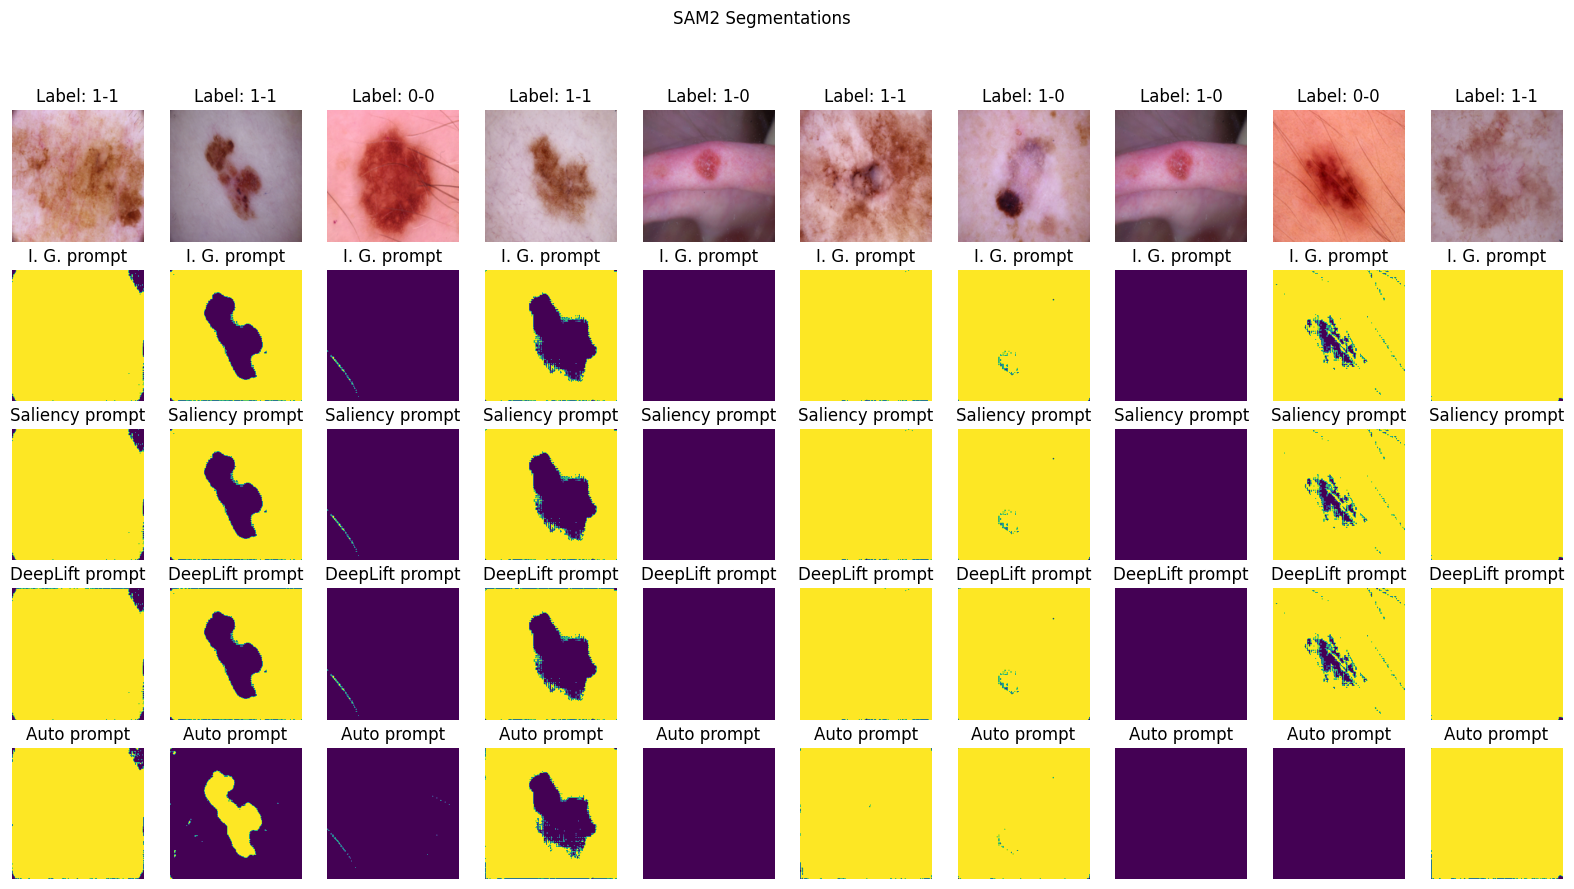

In [24]:
fig, axs = plt.subplots(5, 10, figsize=(20, 10))

for i in range(10):
    axs[0,i].imshow(images[i].squeeze().permute(1, 2, 0))
    axs[0,i].set_title(f"Label: {labels[i].item()}-{sam2_segmentations_dict['label_predicted'][i]}")
    axs[0,i].axis("off")
    axs[1,i].imshow(sam2_segmentations_dict['ig'][i].squeeze())
    axs[1,i].set_title("I. G. prompt")
    axs[1,i].axis("off")
    axs[2,i].imshow(sam2_segmentations_dict['saliency'][i].squeeze())
    axs[2,i].set_title("Saliency prompt")
    axs[2,i].axis("off")
    axs[3,i].imshow(sam2_segmentations_dict['deep_lift'][i].squeeze())
    axs[3,i].set_title("DeepLift prompt")
    axs[3,i].axis("off")
    axs[4,i].imshow(sam2_segmentations_dict['auto'][i].squeeze())
    axs[4,i].set_title("Auto prompt")
    axs[4,i].axis("off")
fig.suptitle("SAM2 Segmentations")
plt.show()